In [ ]:
pip install tensorflow

In [ ]:
import kagglehub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:82: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


In [ ]:
# Step 2: Download dataset from Kaggle
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")
print("Path to dataset files:", path)


Using Colab cache for faster access to the 'imdb-dataset-of-50k-movie-reviews' dataset.
Path to dataset files: /kaggle/input/imdb-dataset-of-50k-movie-reviews


In [ ]:
# Step 3: Load data
df = pd.read_csv(path + "/IMDB Dataset.csv")
print(df.head())

texts = df['review'].values
labels = (df['sentiment'] == "positive").astype(int).values

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [ ]:
# Step 4: Preprocess
vocab_size = 10000
max_len = 200

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded = pad_sequences(sequences, maxlen=max_len, truncating="post")

X_train, X_test, y_train, y_test = train_test_split(padded, labels, test_size=0.2, random_state=42)

In [ ]:
# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.long)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.float32)


In [ ]:
# Step 5: Create Dataset & DataLoader
class IMDBDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = IMDBDataset(X_train, y_train)
test_dataset = IMDBDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [ ]:
# Step 6: Build LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, dropout=0.5):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        output, (hidden, cell) = self.lstm(embedded)
        hidden = self.dropout(hidden[-1])  # last hidden state
        out = self.fc(hidden)
        return self.sigmoid(out)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMModel(vocab_size, embed_dim=64, hidden_dim=128, output_dim=1).to(device)
print(model)

LSTMModel(
  (embedding): Embedding(10000, 64)
  (lstm): LSTM(64, 128, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [ ]:
# Step 7: Loss & Optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Step 8: Train
train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(25):
    model.train()
    epoch_loss, correct, total = 0, 0, 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        predicted = (outputs >= 0.5).float()
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)

    train_loss = epoch_loss / len(train_loader)
    train_acc = correct / total

    # Validation
    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            predicted = (outputs >= 0.5).float()
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)

    val_loss /= len(test_loader)
    val_acc = correct / total

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, "
          f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

Epoch 1: Train Loss=0.5895, Train Acc=0.6983, Val Loss=0.5814, Val Acc=0.7023
Epoch 2: Train Loss=0.5635, Train Acc=0.7083, Val Loss=0.4816, Val Acc=0.7789
Epoch 3: Train Loss=0.4690, Train Acc=0.7856, Val Loss=0.4725, Val Acc=0.7808
Epoch 4: Train Loss=0.4813, Train Acc=0.7792, Val Loss=0.4496, Val Acc=0.8039
Epoch 5: Train Loss=0.3717, Train Acc=0.8401, Val Loss=0.3670, Val Acc=0.8314
Epoch 6: Train Loss=0.3010, Train Acc=0.8773, Val Loss=0.3566, Val Acc=0.8413
Epoch 7: Train Loss=0.2631, Train Acc=0.8954, Val Loss=0.3042, Val Acc=0.8685
Epoch 8: Train Loss=0.2326, Train Acc=0.9100, Val Loss=0.3120, Val Acc=0.8745
Epoch 9: Train Loss=0.2065, Train Acc=0.9222, Val Loss=0.3034, Val Acc=0.8756
Epoch 10: Train Loss=0.1790, Train Acc=0.9352, Val Loss=0.3221, Val Acc=0.8784
Epoch 11: Train Loss=0.1535, Train Acc=0.9461, Val Loss=0.3352, Val Acc=0.8730
Epoch 12: Train Loss=0.1317, Train Acc=0.9548, Val Loss=0.3451, Val Acc=0.8732
Epoch 13: Train Loss=0.1104, Train Acc=0.9634, Val Loss=0.403

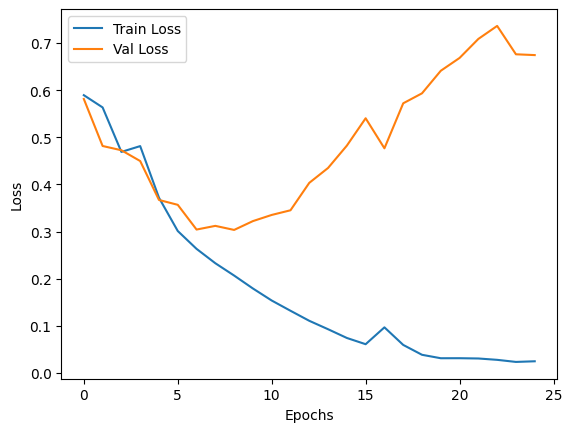

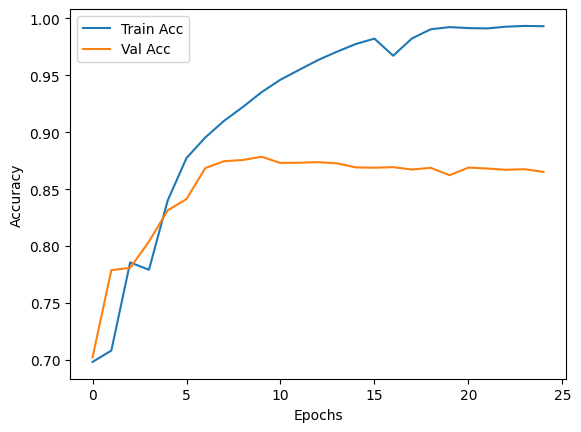

In [ ]:
# Step 9: Plot results
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
